In [123]:
import pandas as pd
import numpy as np
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, NMF, MiniBatchSparsePCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

In [2]:
df = pd.read_pickle('FT-data-DSpace/data_agreggated.pickle')
df = df[['Date', 'Meeting Number', 'Clean']]

In [3]:
df['Sentences'] = df['Clean'].apply(lambda x: ' '.join(x))
df['Date'] = pd.to_datetime(df['Date'])
df.sample(2)

,Date,Meeting Number,Clean,Sentences
634,2015-05-12 13:00:00,90. møde,"[mød, åbn, så, går, anmeld, beskæftigelsesmini...",mød åbn så går anmeld beskæftigelsesminist hen...
96,2010-05-26 13:00:00,97. møde,"[mød, åbn, dag, enkelt, anmeld, indenr, sundhe...",mød åbn dag enkelt anmeld indenr sundhedsminis...


In [150]:
#tvec = TfidfVectorizer(min_df=.01, max_df=1.0, sublinear_tf=True, analyzer='word', ngram_range=(1,2), max_features=20000)
tvec = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000)
x = tvec.fit_transform(df['Sentences'])

words = tvec.get_feature_names()

In [151]:
df_x = pd.DataFrame(columns= words, data=x.toarray())
df_x['Date'] = df['Date']
df_x['Year'] = df_x['Date'].dt.year
df_x['Meeting'] = df['Meeting Number']
df_x.sample(2)

,3f,a4,aaen,aaen el,aaen enhedslist,aaen hr,aaen ikk,aaen jam,aaen kan,aaen kort,...,øvr sam,øvr syn,øvr så,øvr tag,øvr udvalg,øvr ved,øvr vær,Date,Year,Meeting
76,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000827,2010-04-19 10:00:00,2010,77. møde
841,0.013042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001727,2017-04-05 13:00:00,2017,79. møde


### PCA

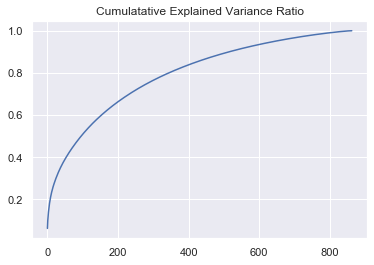

In [153]:
pca = TruncatedSVD(n_components=900, n_iter=10) ## latent semantic analysis (LSA)
pca_result = pca.fit_transform(df_x[words].values)
df_x['pca-one'] = pca_result[:,0]
df_x['pca-two'] = pca_result[:,1] 
df_x['pca-three'] = pca_result[:,2]#
plt.title('Cumulatative Explained Variance Ratio')
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
#Code For Elbow Method
nc = range(1,10)
kmeans = [KMeans(n_clusters = i, n_init = 100, max_iter = 500, precompute_distances = 'auto' ) for i in nc]
score = [kmeans[i].fit(pca_result).score(pca_result) for i in range(len(kmeans))]
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show() ## to find the most optimal K -> optimal K is when the graph levels off


In [142]:
df_x.sample(2)

,3f,aaen,aaen enhedslist,aaen kort,aaen kort bemærkning,aaja,aaja chemnitz,aaja chemnitz lars,aalborg,aalborg portland,...,øvr vær,Date,Year,Meeting,pca-one,pca-two,pca-three,label,tsne_component_one,tsne_component_two
783,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2016-11-25 10:00:00,2016,23. møde,0.720825,0.013521,-0.040431,2,28.232759,-22.434952
52,0.006355,0.032675,0.002446,0.002629,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2010-02-11 10:00:00,2010,53. møde,0.861997,0.048556,-0.007696,2,21.701914,23.085501


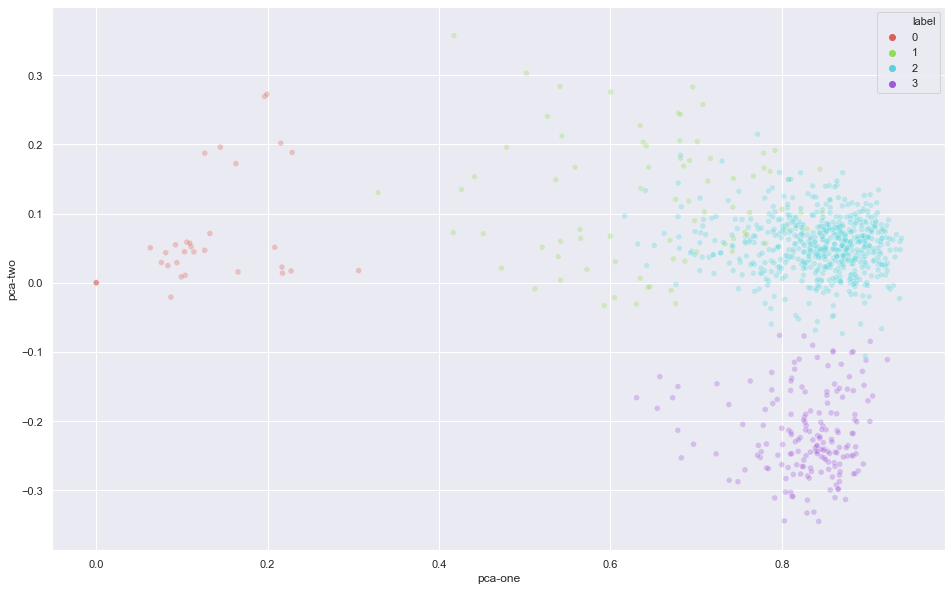

In [143]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue='label',
    palette=sns.color_palette("hls", k),
    data=df_x,
    legend="full",
    alpha=0.3
)

#### T-SNE

In [147]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=35, n_iter=500)
#tsne_results = tsne.fit_transform(df_x[words])
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 863 samples in 0.110s...
[t-SNE] Computed neighbors for 863 samples in 0.953s...
[t-SNE] Computed conditional probabilities for sample 863 / 863
[t-SNE] Mean sigma: 0.168573
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.132919
[t-SNE] KL divergence after 500 iterations: 1.573775
t-SNE done! Time elapsed: 4.255615472793579 seconds


In [148]:
df_x['tsne_component_one'] = tsne_results[:,0]
df_x['tsne_component_two'] = tsne_results[:,1]

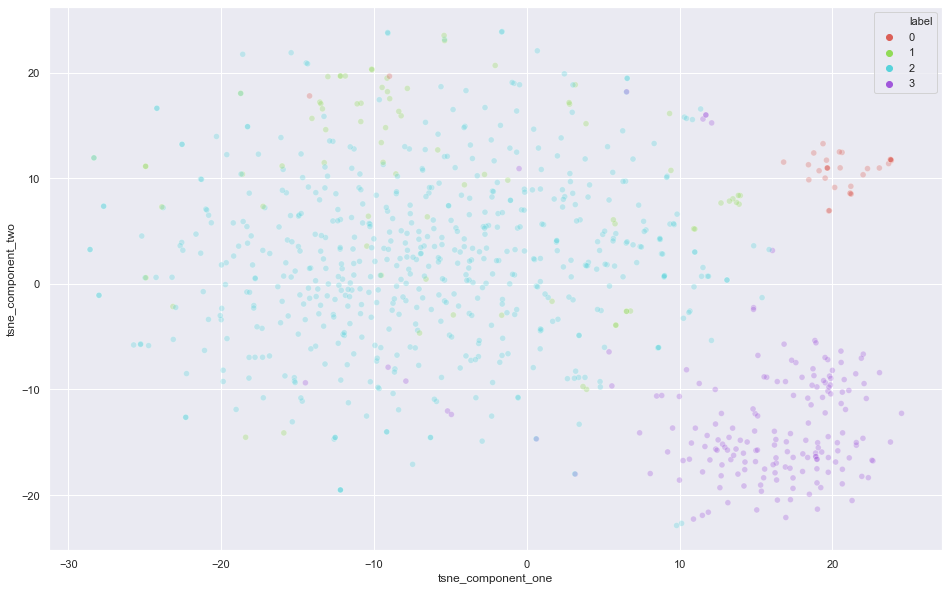

In [149]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_component_one", y="tsne_component_two",
    hue='label',
    palette=sns.color_palette("hls", k),
    data=df_x,
    legend="full",
    alpha=0.3
)

In [ ]:
df_x

In [118]:
tvec.

array([2.61990921, 2.12678317, 3.02537432, ..., 2.59108877, 2.18562367,
       2.42885398])